#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=40

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.91881997,  0.05121301,  0.39134012],
       [ 0.13873972,  0.88635172, -0.44173738],
       [-0.36948769,  0.46017155,  0.80729238]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.005805


In [29]:
Ret

array([[[ 0.91881997,  0.05121301,  0.39134012],
        [ 0.13873972,  0.88635172, -0.44173738],
        [-0.36948769,  0.46017155,  0.80729238]],

       [[ 0.69355969,  0.71974602,  0.03066973],
        [-0.68456401,  0.64520186,  0.33924428],
        [ 0.22438155, -0.25628155,  0.94019822]],

       [[-0.04836072, -0.32867807,  0.94320304],
        [-0.33620676, -0.88384865, -0.32523312],
        [ 0.94054572, -0.33283974, -0.06776023]],

       [[-0.09693095,  0.96349784, -0.24955222],
        [-0.83691341,  0.05680179,  0.54437993],
        [ 0.53868389,  0.26162086,  0.80085841]],

       [[ 0.39429541, -0.26490072, -0.87997656],
        [ 0.90931142,  0.25102296,  0.33187379],
        [ 0.13298072, -0.93102904,  0.33985445]],

       [[-0.43247317,  0.54186738,  0.72065713],
        [ 0.87633583,  0.06455931,  0.47735481],
        [ 0.21213787,  0.83798081, -0.50277797]],

       [[ 0.46503307,  0.37667381,  0.80116234],
        [-0.83875709,  0.47700649,  0.2625859 ],
        

In [30]:
Ret.shape

(40, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([1.26410911e+00, 1.71894695e-02, 5.39843196e-01, 1.62690419e-01,
       6.96727520e-01, 1.18478910e-01, 3.45177404e-01, 1.49191868e-01,
       1.82524368e-01, 1.69718800e-01, 2.30470575e+00, 2.17714348e-01,
       2.77290796e-01, 1.59301961e-01, 5.34317758e-01, 1.39281091e+00,
       3.86933159e+00, 4.82090302e-01, 2.61827807e-01, 9.72831287e-03,
       7.17558531e-01, 3.27730672e-01, 6.57291013e-01, 2.63319021e+00,
       1.32510808e-03, 3.13344087e-02, 1.25952658e-02, 8.90150130e-01,
       2.11103322e+00, 5.81982248e+00, 9.75942609e-01, 5.94418003e-01,
       7.47387069e-01, 1.79168523e+00, 1.25396957e+00, 3.84582547e+00,
       2.56405462e-01, 1.97065282e+00, 2.93717060e-01, 1.47967897e+00])

In [34]:
C1(dx,dy,dz,Ret)

array([[ 1.42764753e-02, -2.17714075e-01, -1.26693840e+00,
         1.35962135e+01,  3.71351160e+00,  4.35874563e-01,
         1.86574171e-01, -6.17863383e-02,  1.54873355e-01,
         5.37587677e-01,  1.98004490e+00,  5.51325583e-01,
         1.26267946e-01, -9.49162908e-01, -1.18034456e-01,
         1.38803676e+00, -9.64546977e-01,  8.40997069e-02,
        -2.01251333e-02, -1.21878559e+00,  1.36991421e+00,
        -1.23665878e-01, -3.92051159e+00, -1.14949953e+00,
         8.76569641e-02, -2.48404157e-01,  2.33133575e-01,
         1.55793744e+00,  6.71031504e+00, -4.58920466e+00,
         9.72686531e-01,  4.92706349e-01,  1.35809369e+00,
         1.71657679e-01,  6.70128125e-01,  3.32550946e+00,
        -1.05268095e+00, -1.89851235e+00,  5.09569088e-01,
        -5.88440506e-02],
       [-2.41543834e-01, -1.27786529e-01,  1.16785267e+00,
        -5.37105141e+00, -1.17813593e+00, -1.96802719e-01,
        -2.89664624e-01,  2.53353959e-01,  3.80680398e-02,
        -2.20285914e+00,  1.26

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 40)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000198


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[ 8.19331761e+01, -1.24946846e+03, -7.27100249e+03,
         7.80291305e+04,  2.13119691e+04,  2.50149891e+03,
         1.07075550e+03, -3.54593892e+02,  8.88823438e+02,
         3.08523392e+03,  1.13635449e+04,  3.16407623e+03,
         7.24656027e+02, -5.44727814e+03, -6.77403746e+02,
         7.96599006e+03, -5.53556783e+03,  4.82651072e+02,
        -1.15498823e+02, -6.99465186e+03,  7.86198416e+03,
        -7.09722672e+02, -2.24999491e+04, -6.59701680e+03,
         5.03066292e+02, -1.42559988e+03,  1.33796150e+03,
         8.94105586e+03,  3.85107257e+04, -2.63376013e+04,
         5.58228101e+03,  2.82765846e+03,  7.79414575e+03,
         9.85149246e+02,  3.84588805e+03,  1.90852117e+04,
        -6.04137167e+03, -1.08956268e+04,  2.92443429e+03,
        -3.37708004e+02],
       [-1.38622826e+03, -7.33371224e+02,  6.70234609e+03,
        -3.08246463e+04, -6.76136209e+03, -1.12945748e+03,
        -1.66239511e+03,  1.45400697e+03,  2.18473773e+02,
        -1.26422834e+04,  7.27

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[ 8.19331761e+01, -1.38622826e+03, -1.99514309e+04],
       [-1.24946846e+03, -7.33371224e+02,  2.06430678e+03],
       [-7.27100249e+03,  6.70234609e+03,  5.31597920e+03],
       [ 7.80291305e+04, -3.08246463e+04, -3.21161190e+04],
       [ 2.13119691e+04, -6.76136209e+03,  1.31110370e+04],
       [ 2.50149891e+03, -1.12945748e+03,  1.29706669e+04],
       [ 1.07075550e+03, -1.66239511e+03, -3.13159105e+02],
       [-3.54593892e+02,  1.45400697e+03,  2.09052289e+03],
       [ 8.88823438e+02,  2.18473773e+02, -5.33167502e+02],
       [ 3.08523392e+03, -1.26422834e+04, -2.44999612e+03],
       [ 1.13635449e+04,  7.27271396e+03, -6.07439065e+03],
       [ 3.16407623e+03, -2.97551790e+03, -1.35143926e+03],
       [ 7.24656027e+02, -1.12932962e+03,  2.15820332e+03],
       [-5.44727814e+03,  2.97820752e+03,  6.80475633e+03],
       [-6.77403746e+02,  6.12630121e+03, -5.55281881e+03],
       [ 7.96599006e+03, -8.97785554e+03,  9.18874926e+03],
       [-5.53556783e+03,  2.08540612e+04

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000209


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000445


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000156


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075],
       [28348.86140075]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.002304


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.003454


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000302


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000580


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        , 3828066.31436059],
       [      0.        ,       0.        ,  387332.82913277],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,  580457.08938404],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,  184818.29777951],
       [      0.        ,       0.        , 1169253.21114714],
       [      0.        ,       0.        ,  706697.5415816 ],
       [      0.        ,       0.        ,  255753.37094837],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.   

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[-8.19331761e+01,  1.24946846e+03,  7.27100249e+03,
        -7.80291305e+04, -2.13119691e+04, -2.50149891e+03,
        -1.07075550e+03,  3.54593892e+02, -8.88823438e+02,
        -3.08523392e+03, -1.13635449e+04, -3.16407623e+03,
        -7.24656027e+02,  5.44727814e+03,  6.77403746e+02,
        -7.96599006e+03,  5.53556783e+03, -4.82651072e+02,
         1.15498823e+02,  6.99465186e+03, -7.86198416e+03,
         7.09722672e+02,  2.24999491e+04,  6.59701680e+03,
        -5.03066292e+02,  1.42559988e+03, -1.33796150e+03,
        -8.94105586e+03, -3.85107257e+04,  2.63376013e+04,
        -5.58228101e+03, -2.82765846e+03, -7.79414575e+03,
        -9.85149246e+02, -3.84588805e+03, -1.90852117e+04,
         6.04137167e+03,  1.08956268e+04, -2.92443429e+03,
         3.37708004e+02],
       [ 1.38622826e+03,  7.33371224e+02, -6.70234609e+03,
         3.08246463e+04,  6.76136209e+03,  1.12945748e+03,
         1.66239511e+03, -1.45400697e+03, -2.18473773e+02,
         1.26422834e+04, -7.27

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000496


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000453


In [91]:
Re_b(Ret).shape

(40, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[8.44230135e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.85619373e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.30344198e+02]],

       [[4.81025040e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.16285438e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.76794537e+02]],

       [[2.33875964e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.81188433e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.18289655e-01]],

       [[9.39560959e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.22644357e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.28274837e+02]],

       [[1.55468869e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.30125276e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.31002095e+01]],

       [[1.87033042e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.16790477e-01, 0.00000000e+00],
    

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000107


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.005062


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.002871


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001978


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.09682383e+08, -1.30715756e+08, -3.00719695e+08],
       [ 2.72817898e+05,  5.28546375e+08,  2.45213167e+06],
       [ 1.21824439e+06, -1.21050624e+06, -5.79795473e+05],
       [-5.19796268e+07,  1.05760703e+07,  1.57101118e+07],
       [ 1.83176429e+07, -8.02045011e+04,  1.74434217e+08],
       [ 1.35659358e+08,  5.07565634e+07, -5.60066996e+07],
       [ 1.33342596e+05, -2.17710071e+08, -3.52404108e+07],
       [ 2.43740345e+08,  1.10383140e+09,  4.57641912e+08],
       [-5.25246042e+04, -1.25698036e+09,  2.19387207e+06],
       [ 1.51089692e+08,  2.15467098e+08,  2.35092856e+08],
       [ 1.81335479e+09,  3.29207880e+08, -1.07777094e+09],
       [-1.83785296e+07, -1.97366802e+08, -1.50631122e+09],
       [-1.39462563e+08, -7.11625279e+07,  6.22608514e+06],
       [ 7.40361947e+06,  8.09113772e+07, -6.51384831e+07],
       [-6.41765786e+08, -3.43969045e+08,  8.61796603e+08],
       [-1.98932550e+08, -5.34295360e+07

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[-8.19331761e+01,  1.24946846e+03,  7.27100249e+03,
        -7.80291305e+04, -2.13119691e+04, -2.50149891e+03,
        -1.07075550e+03,  3.54593892e+02, -8.88823438e+02,
        -3.08523392e+03, -1.13635449e+04, -3.16407623e+03,
        -7.24656027e+02,  5.44727814e+03,  6.77403746e+02,
        -7.96599006e+03,  5.53556783e+03, -4.82651072e+02,
         1.15498823e+02,  6.99465186e+03, -7.86198416e+03,
         7.09722672e+02,  2.24999491e+04,  6.59701680e+03,
        -5.03066292e+02,  1.42559988e+03, -1.33796150e+03,
        -8.94105586e+03, -3.85107257e+04,  2.63376013e+04,
        -5.58228101e+03, -2.82765846e+03, -7.79414575e+03,
        -9.85149246e+02, -3.84588805e+03, -1.90852117e+04,
         6.04137167e+03,  1.08956268e+04, -2.92443429e+03,
         3.37708004e+02],
       [ 1.38622826e+03,  7.33371224e+02, -6.70234609e+03,
         3.08246463e+04,  6.76136209e+03,  1.12945748e+03,
         1.66239511e+03, -1.45400697e+03, -2.18473773e+02,
         1.26422834e+04, -7.27

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[ 0.00000000e+00, -2.16744386e+06,  2.28600478e+06,
         1.28642483e+04, -2.22013194e+05,  7.28926802e+05,
        -5.34504924e+05, -4.58640751e+03, -2.83656285e+05,
         6.14403306e+05,  1.48181044e+06, -7.05951996e+06,
         3.93530725e+06, -2.27538831e+06,  2.11525952e+06,
        -1.65671874e+06,  9.27533160e+05, -3.15846098e+05,
         1.31202168e+06, -6.60546452e+05, -1.42177193e+05,
        -5.41142272e+05,  2.28097903e+06, -4.87796607e+05,
        -8.40618113e+04, -1.36747881e+06,  1.94066131e+06,
        -1.19999950e+06,  3.83616521e+05, -7.01324948e+05,
         8.57833040e+05,  3.42562286e+05, -1.71446839e+06,
         2.06958396e+06, -1.29159397e+06,  4.08240115e+06,
        -7.12734566e+06,  2.25605275e+05, -3.02205879e+06,
         2.86608513e+06],
       [ 0.00000000e+00, -9.02059835e+05,  7.46460047e+05,
         6.56806607e+04, -4.98304394e+04,  5.62377496e+04,
         5.67763293e+05, -1.28990630e+06,  6.91526895e+06,
        -1.21680623e+07,  3.83

In [111]:
Re_b(Ret).shape

(40, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[-8.19331761e+01,  1.38622826e+03,  1.98232664e+04],
       [ 1.24946846e+03,  7.33371224e+02, -2.19247132e+03],
       [ 7.27100249e+03, -6.70234609e+03, -5.44414375e+03],
       [-7.80291305e+04,  3.08246463e+04,  3.19879545e+04],
       [-2.13119691e+04,  6.76136209e+03, -1.32392016e+04],
       [-2.50149891e+03,  1.12945748e+03, -1.30988315e+04],
       [-1.07075550e+03,  1.66239511e+03,  1.84994563e+02],
       [ 3.54593892e+02, -1.45400697e+03, -2.21868743e+03],
       [-8.88823438e+02, -2.18473773e+02,  4.05002960e+02],
       [-3.08523392e+03,  1.26422834e+04,  2.32183158e+03],
       [-1.13635449e+04, -7.27271396e+03,  5.94622611e+03],
       [-3.16407623e+03,  2.97551790e+03,  1.22327472e+03],
       [-7.24656027e+02,  1.12932962e+03, -2.28636786e+03],
       [ 5.44727814e+03, -2.97820752e+03, -6.93292088e+03],
       [ 6.77403746e+02, -6.12630121e+03,  5.42465427e+03],
       [-7.96599006e+03,  8.97785554e+03, -9.31691380e+03],
       [ 5.53556783e+03, -2.08540612e+04

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ -25.53198064, -111.48174299, -120.9623984 ,   39.25999107,
        -115.65765224, -166.83748677,  161.70618861, -145.41946233,
         -43.32862807,  -93.82368063,  -50.58288215,  -23.42863864,
          -1.11525547,  157.54522245,  139.03550236,  -10.43702934,
         -97.33902184,  -54.5890059 ,   48.30401651,  159.86208137,
         -94.6052594 ,  -38.25268879,  -21.65825886,  -28.23784233,
         -45.34288972, -106.03563698,   -3.27141505,  179.35244368,
        -101.59014802,  -61.00916245,  138.59727713,    1.72856991,
         -10.76559482,    5.49567513,   14.17629679,   12.25859237,
          15.60727803,   53.92179465,   76.72410397,  133.02102652]),
 array([ -26.13848945,  -44.44302029, -102.9572152 ,  359.02871884,
          36.00247722,  -62.86645539, -215.83573785,   54.13355428,
          -4.02027023,   16.98981372,  109.41147659,   65.98538151,
          23.64940831,  -22.10799243,  -63.01072305,  -15.85584284,
           2.74354376,   84.87

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[ 7.67141745e+03, -6.15313116e+03,  3.64946145e+04],
       [ 2.57664793e+03, -3.92580797e+02, -4.16142078e+03],
       [ 3.98735280e+03, -1.45243084e+03,  3.99427010e+03],
       [-4.87488774e+04,  1.15292767e+05,  2.36371114e+04],
       [-1.98560833e+04, -1.53143417e+04, -2.68677085e+04],
       [-1.02474179e+04, -7.24256885e+03, -6.09722652e+03],
       [-7.94300844e+02,  3.40204910e+03, -7.32324708e+02],
       [ 8.51271853e+02, -3.79099751e+03, -3.42460337e+03],
       [-1.28710329e+03, -3.00552726e+02,  1.31955284e+03],
       [ 2.38287810e+03,  2.22618727e+03, -3.70656721e+03],
       [-1.01419924e+04, -1.02266947e+04,  2.03393471e+04],
       [-6.39951417e+03,  2.60090468e+03,  4.34626887e+03],
       [ 5.89719403e+02,  2.48908724e+03, -4.14418006e+03],
       [ 1.27300935e+04, -8.75669731e+03, -7.35435652e+03],
       [-4.00217368e+03, -1.27521448e+04,  6.69629434e+03],
       [-1.60390576e+04,  1.93605328e+04, -1.69254199e+04],
       [-1.51446694e+04, -3.51116696e+04

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[-8.19331761e+01,  1.38622826e+03,  1.98232664e+04],
       [ 1.24946846e+03,  7.33371224e+02, -2.19247132e+03],
       [ 7.27100249e+03, -6.70234609e+03, -5.44414375e+03],
       [-7.80291305e+04,  3.08246463e+04,  3.19879545e+04],
       [-2.13119691e+04,  6.76136209e+03, -1.32392016e+04],
       [-2.50149891e+03,  1.12945748e+03, -1.30988315e+04],
       [-1.07075550e+03,  1.66239511e+03,  1.84994563e+02],
       [ 3.54593892e+02, -1.45400697e+03, -2.21868743e+03],
       [-8.88823438e+02, -2.18473773e+02,  4.05002960e+02],
       [-3.08523392e+03,  1.26422834e+04,  2.32183158e+03],
       [-1.13635449e+04, -7.27271396e+03,  5.94622611e+03],
       [-3.16407623e+03,  2.97551790e+03,  1.22327472e+03],
       [-7.24656027e+02,  1.12932962e+03, -2.28636786e+03],
       [ 5.44727814e+03, -2.97820752e+03, -6.93292088e+03],
       [ 6.77403746e+02, -6.12630121e+03,  5.42465427e+03],
       [-7.96599006e+03,  8.97785554e+03, -9.31691380e+03],
       [ 5.53556783e+03, -2.08540612e+04

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0,
  283.4021754990159,
  566.8043509980319,
  850.2065264970478,
  1133.6087019960637,
  1417.0108774950795,
  1700.4130529940956,
  1983.8152284931116,
  2267.2174039921274,
  2550.619579491143,
  2834.021754990159,
  3117.4239304891753,
  3400.826105988191,
  3684.228281487207,
  3967.630456986223,
  4251.0326324852385,
  4534.434807984255,
  4817.836983483271,
  5101.239158982286,
  5384.641334481303,
  5668.043509980318,
  5951.445685479334,
  6234.847860978351,
  6518.250036477366,
  6801.652211976382,
  7085.0543874753985,
  7368.456562974414,
  7651.85873847343,
  7935.260913972446,
  8218.663089471462,
  8502.065264970477,
  8785.467440469494,
  9068.86961596851,
  9352.271791467525,
  9635.673966966542,
  9919.076142465557,
  10202.478317964573,
  10485.88049346359,
  10769.282668962605,
  11052.68484446162],
 [0.0,
  0.45595784671552586,
  1.8238361078331267,
  4.103648946148533,
  7.295419966536416,
  11.399182216224183,
  16.414978184967982,
  22.34285980571763,
  29.1

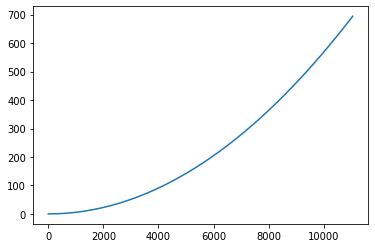

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
# #         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([0.00000000e+00, 2.83402175e+02, 5.66804351e+02, 8.50206526e+02,
       1.13360870e+03, 1.41701088e+03, 1.70041305e+03, 1.98381523e+03,
       2.26721740e+03, 2.55061958e+03, 2.83402175e+03, 3.11742393e+03,
       3.40082611e+03, 3.68422828e+03, 3.96763046e+03, 4.25103263e+03,
       4.53443481e+03, 4.81783698e+03, 5.10123916e+03, 5.38464133e+03,
       5.66804351e+03, 5.95144569e+03, 6.23484786e+03, 6.51825004e+03,
       6.80165221e+03, 7.08505439e+03, 7.36845656e+03, 7.65185874e+03,
       7.93526091e+03, 8.21866309e+03, 8.50206526e+03, 8.78546744e+03,
       9.06886962e+03, 9.35227179e+03, 9.63567397e+03, 9.91907614e+03,
       1.02024783e+04, 1.04858805e+04, 1.07692827e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)
    def tau(self, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(dη, ddη)

In [135]:
tau_force

array([0.0000e+00, 0.0000e+00, 6.0000e+06, 1.4296e+10, 2.6212e+10,
       0.0000e+00])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
sampleTime = 0.001                # sample time [seconds]
N = 30_000                         # number of samples

In [138]:
N

30000

In [139]:
vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [140]:
[simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [141]:
vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [142]:
[simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [143]:
simData_1.shape

(30001, 24)

In [144]:
simData=np.concatenate([simData_1,simData_2], axis=0)

In [145]:
simData.shape

(60002, 24)

In [146]:
# ans_t = simTime_1

In [147]:
simData[250]

array([-6.63029020e-12,  4.17255719e-05, -1.59086538e-11, -7.68709242e-07,
        1.56609043e-13,  3.73683526e-07,  3.36917350e-11,  6.39806672e-04,
       -7.11374023e-14, -1.17683176e-05,  4.34396772e-13,  5.73147391e-06,
        2.09564547e+02,  1.99357036e+02,  4.05735149e+02,  3.67159658e+02,
       -3.55128895e+02,  3.55129058e+02,  4.63634821e+01,  4.41051061e+01,
        8.97620683e+01,  8.12271929e+01, -7.85693520e+01,  7.85693599e+01])

In [148]:
simData.shape

(60002, 24)

In [149]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

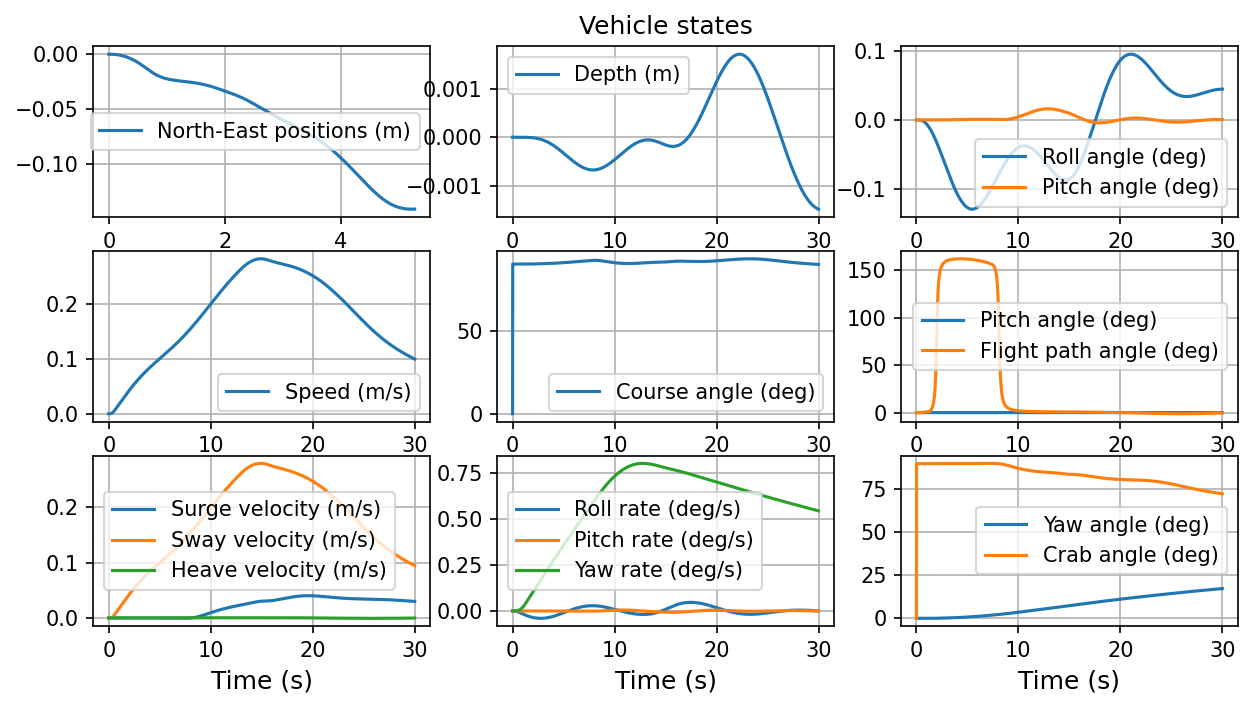

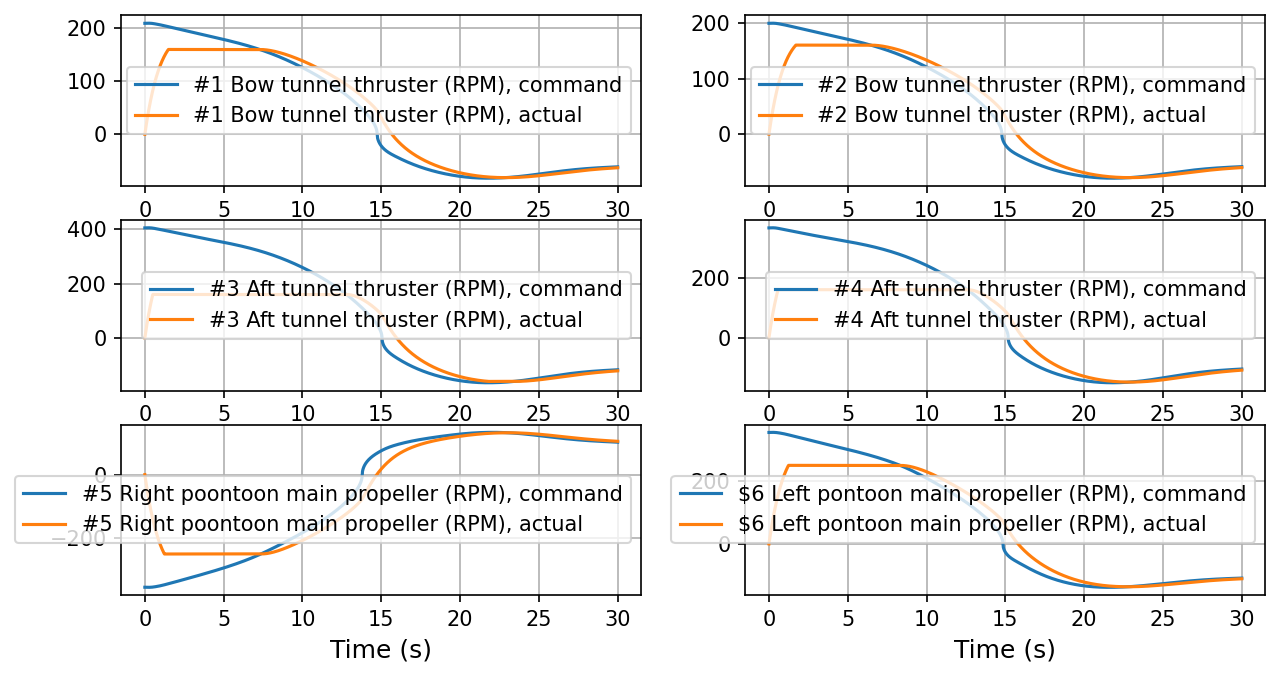

In [150]:
plotVehicleStates(simTime_1, simData_1, 1)                    
plotControls(simTime_1, simData_1, vehicle_1, 2)

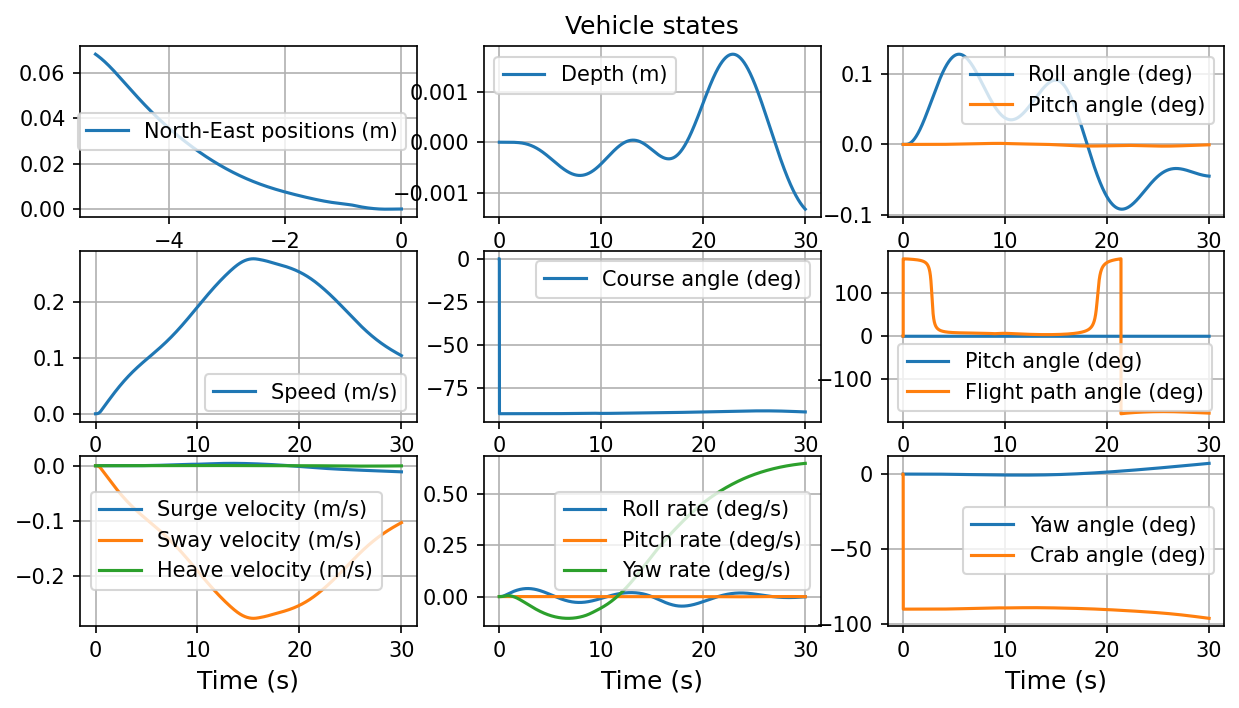

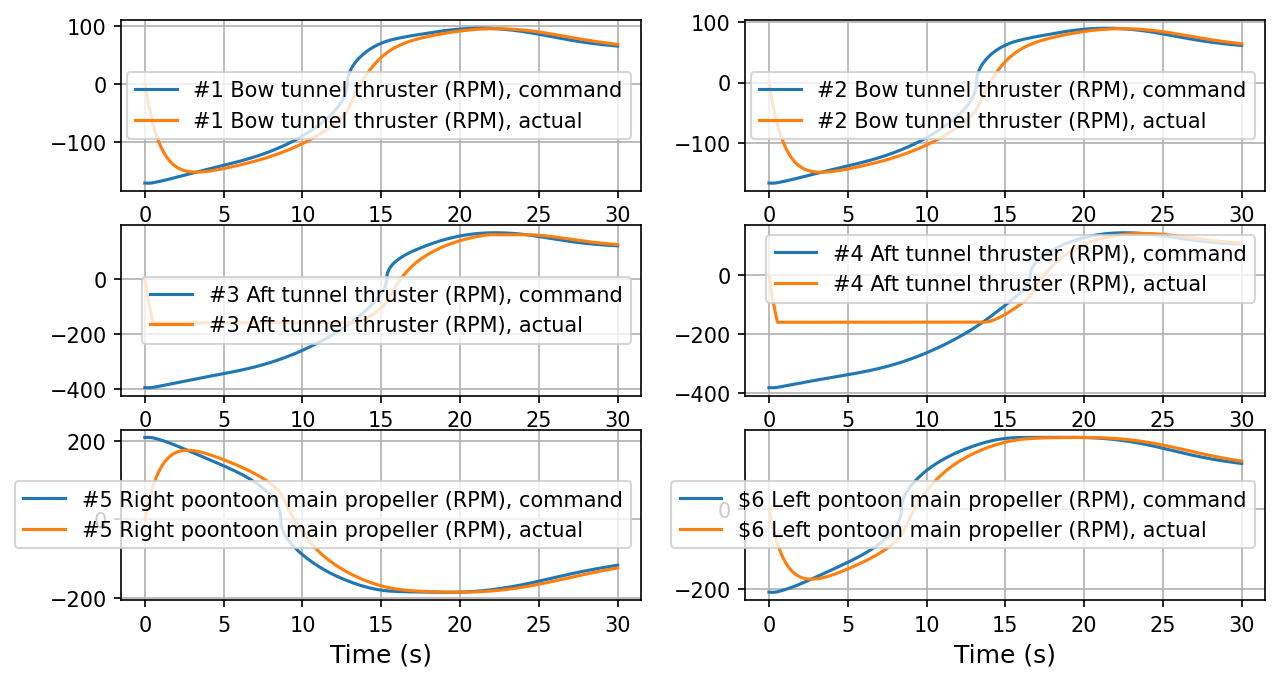

In [151]:
plotVehicleStates(simTime_2, simData_2, 1)                    
plotControls(simTime_2, simData_2, vehicle_2, 2)

In [152]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'                  # browser for visualization of animated GIF

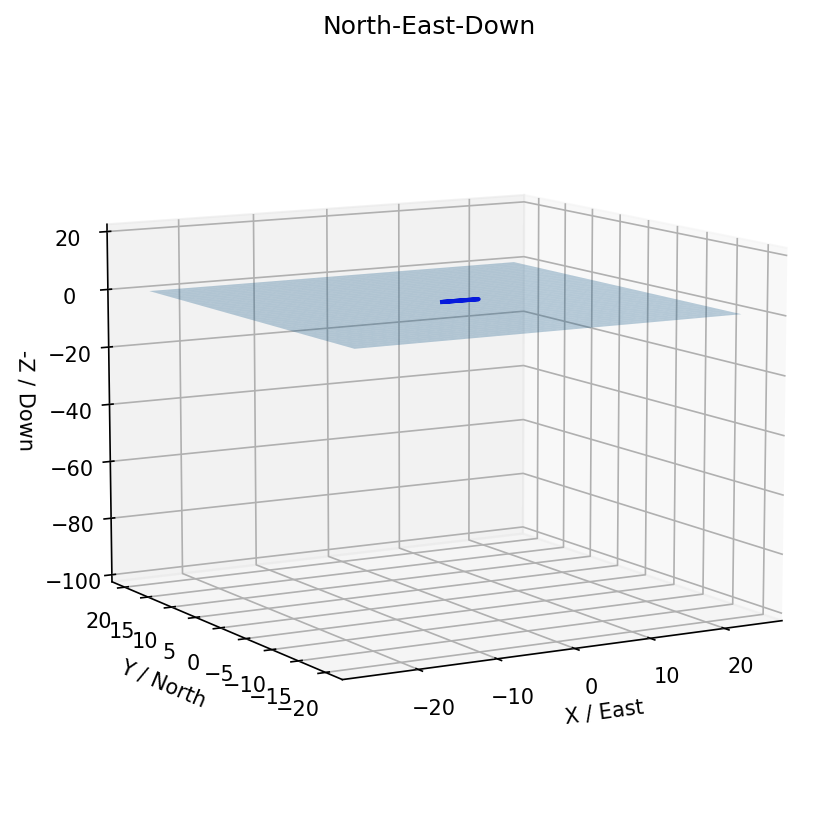

In [153]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [154]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [155]:
# simData[1]

In [156]:
simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [157]:
diff_1=np.diff(simD_1,axis=0)
diff_2=np.diff(simD_2,axis=0)

In [158]:
diff=np.concatenate([diff_1,diff_2], axis=0)

In [159]:
diff.shape

(60002, 24)

In [160]:
V=VesselSemisub()

In [161]:
# thres =0.1

In [162]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [163]:
simD=np.concatenate([simD_1,simD_2], axis=0)

In [164]:
simD.shape

(60004, 24)

In [165]:
SD0=simD[:, 0]
SD1=simD[:, 1]
SD2=simD[:, 2]
SD3=simD[:, 3]
SD4=simD[:, 4]
SD5=simD[:, 5]
SD6=simD[:, 6]
SD7=simD[:, 7]
SD8=simD[:, 8]
SD9=simD[:, 9]
SD10=simD[:, 10]
SD11=simD[:, 11]
Diff6=diff[:, 6]
Diff7=diff[:, 7]
Diff8=diff[:, 8]
Diff9=diff[:, 9]
Diff10=diff[:, 10]
Diff11=diff[:, 11]

In [166]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [167]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [168]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [169]:
# q0

In [170]:
# Jv(x, y, z )

In [171]:
# class Time:
#     def __init__(self):
#         self.time=0
#         self.n=1
# # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # #         self.my_n=0
# #         self.my_update=up

In [172]:
# co=Time()

In [173]:
from scipy.integrate import solve_ivp

In [174]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
#     print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
#     co.time += 0.1
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
    idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print(idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
    x_ve = SD0[idx]
    y_ve = SD1[idx]
    z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(simData[:, 3][idx]))
#     theta_ve = R2D(ssa(simData[:, 4][idx]))
#     psi_v = R2D(ssa(simData[:, 5][idx]))
    phi_ve = ssa(SD3[idx])
    theta_ve = ssa(SD4[idx])
    psi_v = ssa(SD5[idx])
    u_ve = SD6[idx]
    v_ve = SD7[idx]
    w_ve = SD8[idx]
    p_ve = SD9[idx]
    q_ve = SD10[idx]
    r_ve = SD11[idx]
    
    
#     print(t-co.time)
    du_ve = Diff6[idx]/sampleTime
    dv_ve = Diff7[idx]/sampleTime
    dw_ve = Diff8[idx]/sampleTime
    dp_ve = Diff9[idx]/sampleTime
    dq_ve = Diff10[idx]/sampleTime
    dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
    tau_force = V.tau(dη, ddη)
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
    Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
       - Z0
      )
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
    
    ddx,ddy, ddz = (1/Ws*Z).T
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
        
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T  
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    B =(-C2+C3+C4+C5 
        +C0.squeeze()
       )
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T 
#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
# #     print(ans_ψ)

#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [175]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [176]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [177]:
# q0.shape

In [178]:
# import numpy as np

In [179]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [180]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [181]:
# grayscott1d(4,q0)

In [182]:
# grayscott1d(4,q0).shape

In [183]:
tspan = (0., 0.1)

In [184]:
q0

array([0.00000000e+00, 2.83402175e+02, 5.66804351e+02, 8.50206526e+02,
       1.13360870e+03, 1.41701088e+03, 1.70041305e+03, 1.98381523e+03,
       2.26721740e+03, 2.55061958e+03, 2.83402175e+03, 3.11742393e+03,
       3.40082611e+03, 3.68422828e+03, 3.96763046e+03, 4.25103263e+03,
       4.53443481e+03, 4.81783698e+03, 5.10123916e+03, 5.38464133e+03,
       5.66804351e+03, 5.95144569e+03, 6.23484786e+03, 6.51825004e+03,
       6.80165221e+03, 7.08505439e+03, 7.36845656e+03, 7.65185874e+03,
       7.93526091e+03, 8.21866309e+03, 8.50206526e+03, 8.78546744e+03,
       9.06886962e+03, 9.35227179e+03, 9.63567397e+03, 9.91907614e+03,
       1.02024783e+04, 1.04858805e+04, 1.07692827e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, method='BDF')
print(datetime.now() - startTime1)

In [ ]:
# co.my_time

In [ ]:
fin=us.u

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
# !pip3 install diffeqpy

In [ ]:
# node_N

In [ ]:
# t

In [ ]:
# plt.plot(us.t,us.u)
# plt.show()

In [ ]:
# node_N

In [ ]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [ ]:
# fin

In [ ]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [ ]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin[0][[i for i in range(0,node_N)]]
Y0=fin[0][[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0][[i for i in range(4*node_N,5*node_N)]]
X=fin[-1][[i for i in range(0,node_N)]]
Y=fin[-1][[i for i in range(2*node_N,3*node_N)]]
Z=fin[-1][[i for i in range(4*node_N,5*node_N)]]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)